# Assignment 4: Classification

This assignment needs assign4_train.csv and assign4_test.csv. assign4_train.csv is for training and assign4_test.csv is for test. Both of them have samples in the following format:

|label | text |
|------|------|
|1|  I must admit that I'm addicted to "Version 2.0...|
|0|  I think it's such a shame that an enormous tal...|
|1|  The Sunsout No Room at The Inn Puzzle has oddl...|
|...|...|


## Q1 Classification 

Write a function **classify** to conduct a classification experiement as follows: 
1. Take the training and testing file names (strings) as inputs, i.e. classify (training_file, testing_file). 
2. Classify text samples in the training file using **Linear SVM** as follows: 
   - a. First apply grid search with **6-fold cross validation** to find the best values for parameters **min_df**, **stop_words**, and **C** of Linear SVM that are used the modeling pipeline. Use f1-macro as the scoring metric to select the best parameter values. Potential values for these parameters are: 
      * min_df' : [1,2,3]
      * stop_words' : [None,"english"]
      * C: [0.5,1,5] 
   - b. Using the best parameter values, **train a Linear SVM with all samples** in the training file 
3. Test the classifier created in Step 2.b using the test file. Report the testing performance as: 
   - Precision, recall, and f1-score of each label 
   - Treat label 1 as the positive class, plot precision-recall curve and ROC curve, and calculate AUC, Average Precision (sklearn.metrics.average_precision_score). Note, LinearSVC does not ouput probability, but you can use **decision_function** to calculate AUC (https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC.decision_function) 
4. Your function "classify" has no return. However, when this function is called, the best parameter values from grid search is printed and the testing performance from Step 3 is printed. 

## Q2. How to determine **K** in k-fold cross validation?  

This question will use assign4_train.csv dataset. Use this experiment to find the best **k** for k-fold cross validation.

Write a function "K_fold_CV" as follows:
- Take the full file name path string for a dataset as an input, e.g. K_fold_CV(dataset_file). 
- Create tf-idf matrix using TfidfVectorizer 
- Conduct k-fold cross validation for different $k$ values varying from 2 to 20. For each $k$, do the following:
    1. train a classifier using **multinomial Naive Bayes** model with k-fold cross validation 
    2. train a classifier using **linear support vector machine** model with k-fold cross validation 
    3. for each classifier, collect the average AUC across $k$ folds (treat label 1 as the positive class). Hint, for binary classification, you can set "roc_auc" as the value of "metric" parameter of function "cross_validate". 
- Plot a line chart to show **the relationship between sample size and AUC**  
- Write your analysis in a **separate pdf file (not in code)** on the following: 
  - How does $k$ affect model performance on evaluation sets? 
  - By varying $k$, you also change sample size for training. How can the sample size affect model performance? 
- There is no return for this function, but the charts should be plotted.

## Q3 (Bonus): Ensemble Models by Stacking

An emsemble model combines decisions from multiple models to improve the overall performance. This question askes you to implement an emsemble model by stacking. The details of this technique and sample code can be found at https://www.analyticsvidhya.com/blog/2018/06/comprehensive-guide-for-ensemble-models/. 

Define a function **stacking** to achieve the following:
- Take the training and testing file names (strings) as inputs, i.e. stacking(training_file, testing_file). 
- Train Naive Bayes and Linear SVM using 6-fold cross validation as two base models
- Following the procedure for stacking, train a decision tree or random forest as the top model using the predictions from the base models
- Test the ensemble model performance using the testing dataset and print out precision, recall and F-1 score. 

This function has not return. Note, this ensemble model may not give you a better performance than base models. Just take this chance to learn how to create ensemble models by stacking. This is a very useful technique.

In [54]:
import pandas as pd
import nltk

from sklearn.model_selection import cross_validate
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

import numpy as np
from matplotlib import pyplot as plt
import spacy
import scipy 


In [55]:
# Q1

def classify(train_file, test_file):
             
    train=pd.read_csv(train_file, header=0)
    test=pd.read_csv(test_file, header=0)
    
    # search for best parameters
    text_clf = Pipeline([('tfidf', TfidfVectorizer()),
                    # ('clf', MultinomialNB())
                     ('clf', svm.LinearSVC())
                   ])

    parameters = {'tfidf__min_df':[1,2,3],
              'tfidf__stop_words':[None,"english"],
              'clf__C': [0.5,1,5]  }

    metric =  "f1_macro"

    gs_clf = GridSearchCV(text_clf, param_grid=parameters, scoring=metric, cv=5)
    

    gs_clf = gs_clf.fit(train["text"], train["label"])
    
    
    for param_name in sorted(parameters.keys()):
        print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))

    print("best f1_macro:", gs_clf.best_score_)
    
    # use best parameters to train models
    
    tfidf_vect = TfidfVectorizer(stop_words=gs_clf.best_params_['tfidf__stop_words'],\
                                min_df=gs_clf.best_params_['tfidf__min_df']) 
    
    dtm= tfidf_vect.fit_transform(train["text"])

    clf = svm.LinearSVC(C=gs_clf.best_params_['clf__C']).fit(dtm, train["label"])
    
    # test model
    dtm_test=tfidf_vect.transform(test["text"])
    predicted=clf.predict(dtm_test)

    labels=sorted(train["label"].unique())
    
    #print(classification_report(test["label"], predicted, target_names=mlb.classes_))

    print(classification_report(test["label"], predicted, labels=labels))
    
    
    # generate 2 class dataset
    X, y = make_classification(n_samples=1000, n_classes=2, random_state=1)
# split into train/test sets
    trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)
# generate a no skill prediction (majority class)
    ns_probs = [0 for _ in range(len(testy))]
# fit a model
    model = LogisticRegression(solver='lbfgs')
    model.fit(trainX, trainy)
# predict probabilities
    lr_probs = model.predict_proba(testX)
# keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]
# calculate scores
    ns_auc = roc_auc_score(testy, ns_probs)
    lr_auc = roc_auc_score(testy, lr_probs)
    
    
    # Average AUC
    
    
    print('AUC: %.3f' % (lr_auc))
    

# calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)
# plot the roc curve for the model
    pyplot.plot(ns_fpr, ns_tpr, linestyle='--')#, label='No Skill')
    pyplot.plot(lr_fpr, lr_tpr, marker='.')#, label='Logistic')
# axis labels
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
# show the title
    #pyplot.legend()
    plt.title('AUC of Naive Bayes Model')
# show the plot
    pyplot.show()
    
    
    
    
    # precision-recall curve and f1

# generate 2 class dataset
    X, y = make_classification(n_samples=1000, n_classes=2, random_state=1)
# split into train/test sets
    trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)
# generate a no skill prediction (majority class)
    no_skill_probs = [0 for _ in range(len(testy))]
# fit a model
    model = LogisticRegression(solver='lbfgs')
    model.fit(trainX, trainy)
# predict probabilities
    lr_probs = model.predict_proba(testX)
# keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]
# predict class values
    yhat = model.predict(testX)
# calculate precision and recall for each threshold
    ns_precision, ns_recall, _ = precision_recall_curve(testy, no_skill_probs)
    lr_precision, lr_recall, _ = precision_recall_curve(testy, lr_probs)
# calculate scores
    ns_f1, ns_auc = f1_score(testy, no_skill_probs), auc(ns_recall, ns_precision)
    lr_f1, lr_auc = f1_score(testy, yhat), auc(lr_recall, lr_precision)
# summarize scores
    #print('No Skill: f1=%.3f auc=%.3f' % (ns_f1, ns_auc))
    #print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
    print('Average Precision: %.3f' % (lr_f1))
    
# plot the precision-recall curves
    #pyplot.plot(ns_recall, ns_precision, linestyle='--')#, label='No Skill')
    pyplot.plot(lr_recall, lr_precision, marker='.',color='darkorange')#, label='Logistic')
# axis labels
    pyplot.xlabel('Recall')
    pyplot.ylabel('Precision')
# show the title
    #pyplot.legend()
    plt.title('Precision_Recall_Curve of Naive Bayes Model')
# show the plot
    pyplot.show()

Q1
clf__C: 0.5
tfidf__min_df: 1
tfidf__stop_words: None
best f1_macro: 0.8098463177846511
              precision    recall  f1-score   support

           0       0.77      0.83      0.80       248
           1       0.82      0.75      0.78       252

    accuracy                           0.79       500
   macro avg       0.79      0.79      0.79       500
weighted avg       0.79      0.79      0.79       500

AUC: 0.903


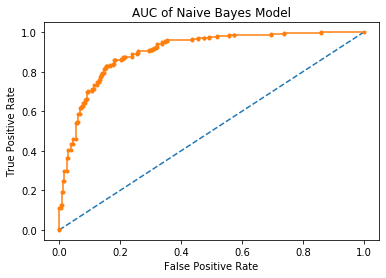

C:\Users\Manish\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Average Precision: 0.841


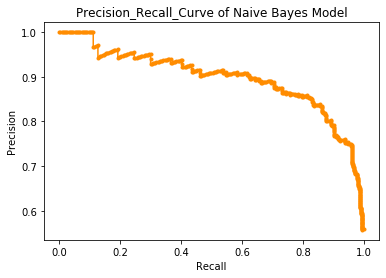

In [56]:
if __name__ == "__main__":  
    # Question 1
    print("Q1")
    classify("assign4_train.csv",\
         "assign4_test.csv")

In [57]:
# Q2

def K_fold_CV(train_file):
# Add YOUR CODE HERE
    data = pd.read_csv(train_file,header=0)
    
    tfidf_vect = TfidfVectorizer(stop_words='english')
    s=list(range(2,20))
    
    metrics = ["roc_auc"]
    clf = MultinomialNB()     
    clf2 = svm.LinearSVC()
    
    roc_auc_nb=[]
    roc_auc_svm=[]
      
    train=data
   
    for i in s:
        
        dtm= tfidf_vect.fit_transform(train["text"])
        binary=train['label'].values
        
        cv1 = cross_validate(clf, dtm, binary, scoring=metrics, cv=i, return_train_score=True)   
        roc_auc_nb.append(np.mean(cv1['test_roc_auc']))
   
        cv2 = cross_validate(clf2, dtm, binary, scoring=metrics, cv=i, return_train_score=True)
        roc_auc_svm.append(np.mean(cv2['test_roc_auc']))      
    
    plt.figure();
    plt.plot(s, roc_auc_nb , color='darkorange');
    plt.plot(s, roc_auc_svm , color='navy');
    plt.xlabel('K');
    plt.legend(["auc_nb","auc_svm"])
    plt.show();



Q2


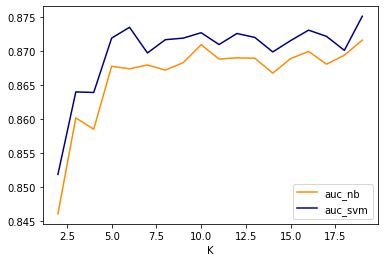

In [58]:
if __name__ == "__main__":  
    
    # Test Q2
    print("\nQ2")
    K_fold_CV("assign4_train.csv")
   

Q1
clf__C: 0.5
tfidf__min_df: 1
tfidf__stop_words: None
best f1_macro: 0.8045970021016776
              precision    recall  f1-score   support

           0       0.77      0.83      0.80       248
           1       0.82      0.75      0.78       252

   micro avg       0.79      0.79      0.79       500
   macro avg       0.79      0.79      0.79       500
weighted avg       0.79      0.79      0.79       500

AUC: 0.881


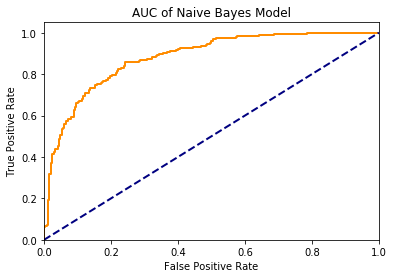

Average Precision: 0.871


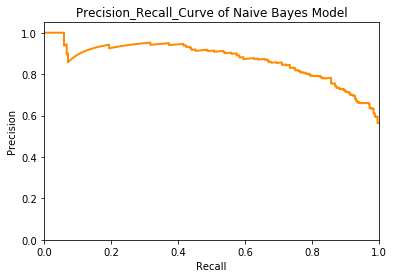


Q2


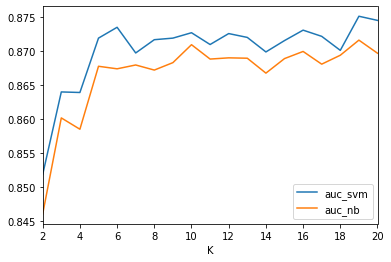


Q3
              precision    recall  f1-score   support

           0       0.79      0.77      0.78      1488
           1       0.78      0.80      0.79      1512

   micro avg       0.78      0.78      0.78      3000
   macro avg       0.78      0.78      0.78      3000
weighted avg       0.78      0.78      0.78      3000



In [187]:
if __name__ == "__main__":  
    # Question 1
    print("Q1")
    classify("../../dataset/assign4_train.csv",\
         "../../dataset/assign4_test.csv")
    
    # Test Q2
    print("\nQ2")
    K_fold_CV("../../dataset/assign4_train.csv")
    
    # Test Q3
    print("\nQ3")
    stacking("../../dataset/assign4_train.csv",\
         "../../dataset/assign4_test.csv")
   